In [220]:
import sys
python = sys.executable # get python executable path
print(python)

for i in ["numpy",  "scipy", "matplotlib", "pandas", "opencv-python", "opencv-contrib-python"]: # declare what packages we need
  print(f"Installing: {i}")
  ! $python -m pip install $i # install packages calling bash command from the notebook, e.g. "/usr/bin/python -m pip install numpy"

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import urllib.request
import cv2

/usr/bin/python3
Installing: numpy
Installing: scipy
Installing: matplotlib
Installing: pandas
Installing: opencv-python
Installing: opencv-contrib-python


## Загрузка изображения

In [221]:
url = "https://upload.wikimedia.org/wikipedia/en/7/7d/Lenna_%28test_image%29.png"
urllib.request.urlretrieve(url, "image.jpg")

('image.jpg', <http.client.HTTPMessage at 0x7c86c25ee920>)

# Задание 1 Чтение и отображение

## Просмотр изображения

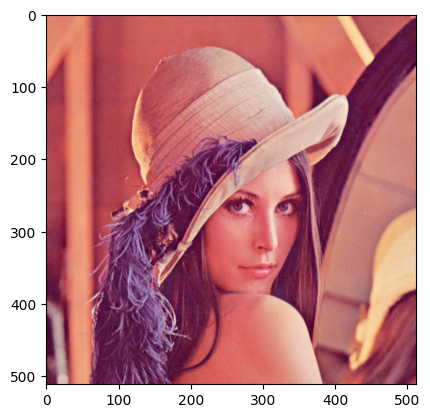

In [222]:
img = cv2.imread("image.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img);

In [223]:
img.shape

(512, 512, 3)

## Отображение каждого канала цвета

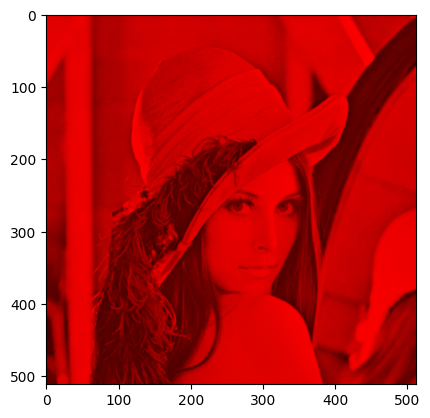

In [224]:
# Красный

image_red = img.copy()
image_red[:, :, 1] = 0
image_red[:, :, 2] = 0
plt.imshow(image_red);

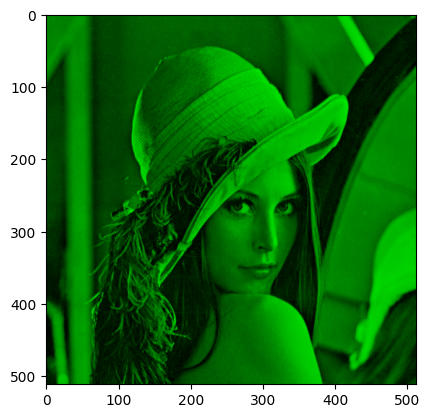

In [225]:
# Зеленый

image_green = img.copy()
image_green[:, :, 0] = 0
image_green[:, :, 2] = 0
plt.imshow(image_green);

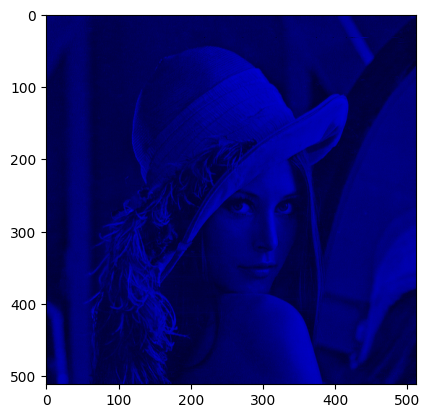

In [226]:
# Синий

image_blue = img.copy()
image_blue[:, :, 0] = 0
image_blue[:, :, 1] = 0
plt.imshow(image_blue);

## Построение гистограммы изображения

Методика построения гистограммы: исходное изображение раскладывается на слои, после этого каждый слой представляется в качестве вариационного ряда, на основании которого уже строится гистограмма.

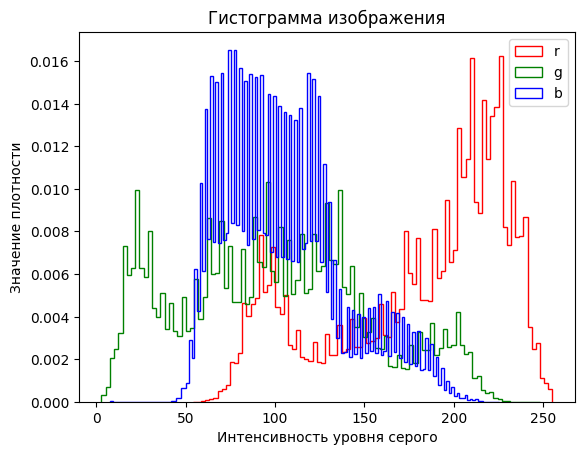

In [227]:
import matplotlib.pyplot as plt


r, g, b = img[:, :, 0].reshape(-1), img[:, :, 1].reshape(-1), img[:, :, 2].reshape(-1)
plt.hist(r, bins='auto', density=True, histtype='step', color='red');
plt.hist(g, bins='auto', density=True, histtype='step', color='green');
plt.hist(b, bins='auto', density=True, histtype='step', color='blue');
plt.title('Гистограмма изображения');
plt.xlabel('Интенсивность уровня серого');
plt.ylabel('Значение плотности');
plt.legend(['r', 'g', 'b']);

# Задание 2 Добавление границы

## Имплементация функции по добавлению границы

In [228]:
def add_border(image: np.ndarray, border_size: int, mode: str, **kwargs) -> np.ndarray:
    """
    mode:
        'constant': добавляет границу черного цвета;
        'edge': дублирование цвета на границе;
        'reflect': отражение относительно краев изображения;
    """
    return np.pad(array=image, pad_width=((border_size, border_size), (border_size, border_size), (0, 0)), mode=mode, **kwargs)

## Добавление константной границы

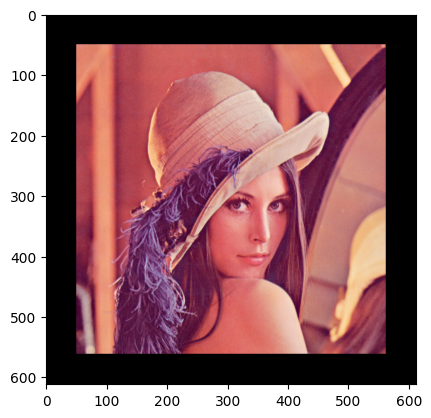

In [229]:
plt.imshow(add_border(img, 50, mode='constant'));

## Дублирование цвета на границе

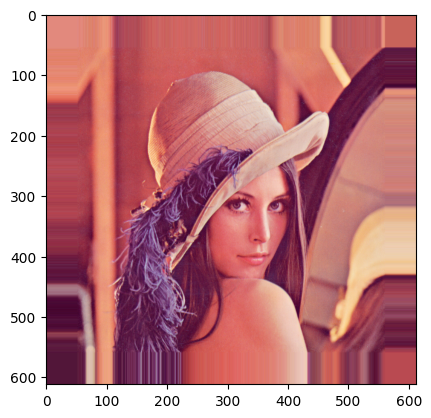

In [230]:
plt.imshow(add_border(img, 50, mode='edge'));

## Отражение относительно краев изображения

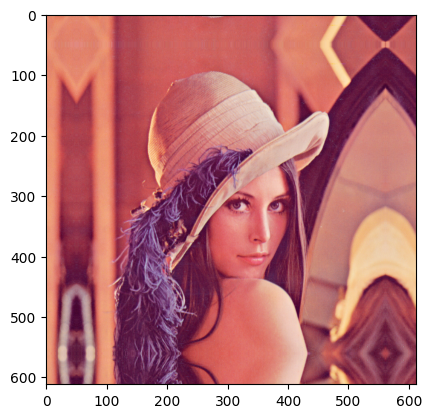

In [231]:
plt.imshow(add_border(img, 50, mode='reflect'));

# Задание 3 RGB  -> GRAY

## Библиотечная реализация (cv2)

In [232]:
cv2_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
cv2_gray.shape

(512, 512)

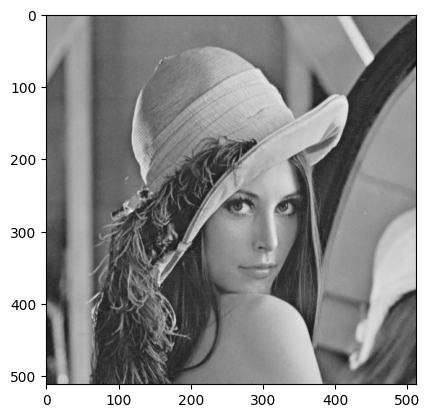

In [233]:
plt.imshow(np.stack((cv2_gray, cv2_gray, cv2_gray), axis=2));

## Имплементация функции по переводу изображения в оттенки серого

Идея функции заключается в том, что она принимает на вход не только изображение, но и коэффициенты, на которые умножаются пиксели соответствующих слоев (это необходимо для того, чтобы взвешивать вклад цветов в различных пропорциях)

In [234]:
# Реализация функции

def rgb_to_gray(image: np.ndarray, coefs: np.ndarray) -> np.ndarray:
    assert image.shape[-1] == len(coefs), f'Число коэффициентов должно совпадать с числом каналов изображения: {len(coefs)} != {image.shape[-1]}'
    return (image.astype(np.float32) * coefs).sum(axis=-1).astype(np.uint8)

In [235]:
# Усреднение

mean_gray = rgb_to_gray(img, np.array([1/3, 1/3, 1/3]))
mean_gray.shape

(512, 512)

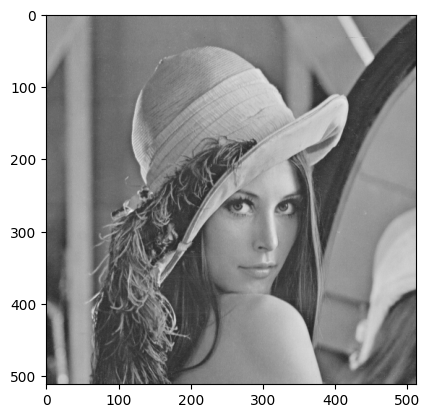

In [236]:
plt.imshow(np.stack((mean_gray, mean_gray, mean_gray), axis=2));

In [237]:
# Взвешивание

prop_gray = rgb_to_gray(img, np.array([.299, .587, .114]))
prop_gray.shape

(512, 512)

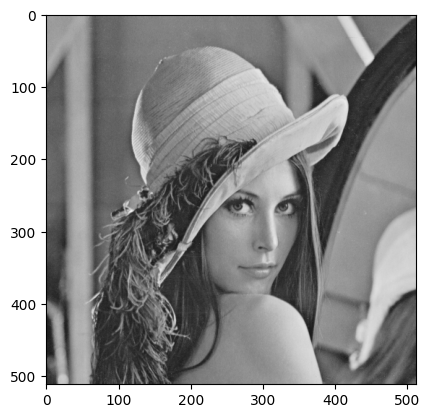

In [238]:
plt.imshow(np.stack((prop_gray, prop_gray, prop_gray), axis=2));

# Задание 4 Манипуляция с пикселями

## Имплементация функций по манипулированию пикселями

Функция shift_image(image, channel, val, clip_value, residue_ring) увеличивает в val канал с номером chanel.

Для того, чтобы работать с различными форматами изображений, такими как RGB и HSV, данная функция имеет параметры clip_value и residue_ring, которые по умолчанию определены как None (они применяются, если значение отлично от None).

Первый параметр отвечает за максимально возможное значение элемента, характеризующего цвет пикселя. Если в результате умножения получилось так, что значение превышает свою допустимую границу, то оно обрежется до clip_value.

Второй параметр отвечает за исследование кольца вычетов по модулю residue_ring. Это необходимо для величин в каналах, которые измеряются градусами на окружности (как, например, Hue).

Для корректной работы округления значений и прведения типов при возвращении значения исследуется тип данных исходного изображения.

In [239]:
def shift_image(image: np.ndarray, channel: int, val: float, clip_value: int | None = None, residue_ring: int | None = None) -> np.ndarray:
    new_image = image.copy().astype(np.float32)
    new_image[:, :, channel] = new_image[:, :, channel] * val
    new_image[:, :, channel] = np.clip(new_image[:, :, channel], a_min=0, a_max=clip_value) if clip_value else new_image[:, :, channel]
    new_image[:, :, channel] = new_image[:, :, channel] % residue_ring if residue_ring else new_image[:, :, channel]
    return new_image.astype(np.uint8 if image.dtype == 'uint8' else np.float32)

In [240]:
# Вспомогательная функция для отображения работы функции shift_image(...) для RGB

def draw_shift(img: np.ndarray, n_channel: int, vals: list) -> None:
    fig, ax = plt.subplots(n_channel, len(vals), figsize=(18, 12))
    for channel in range(n_channel):
        for i, val in enumerate(vals):
            ax[channel, i].set_title(f'channel = {channel}, val = {val}')
            ax[channel, i].imshow(shift_image(img, channel, val, 255))

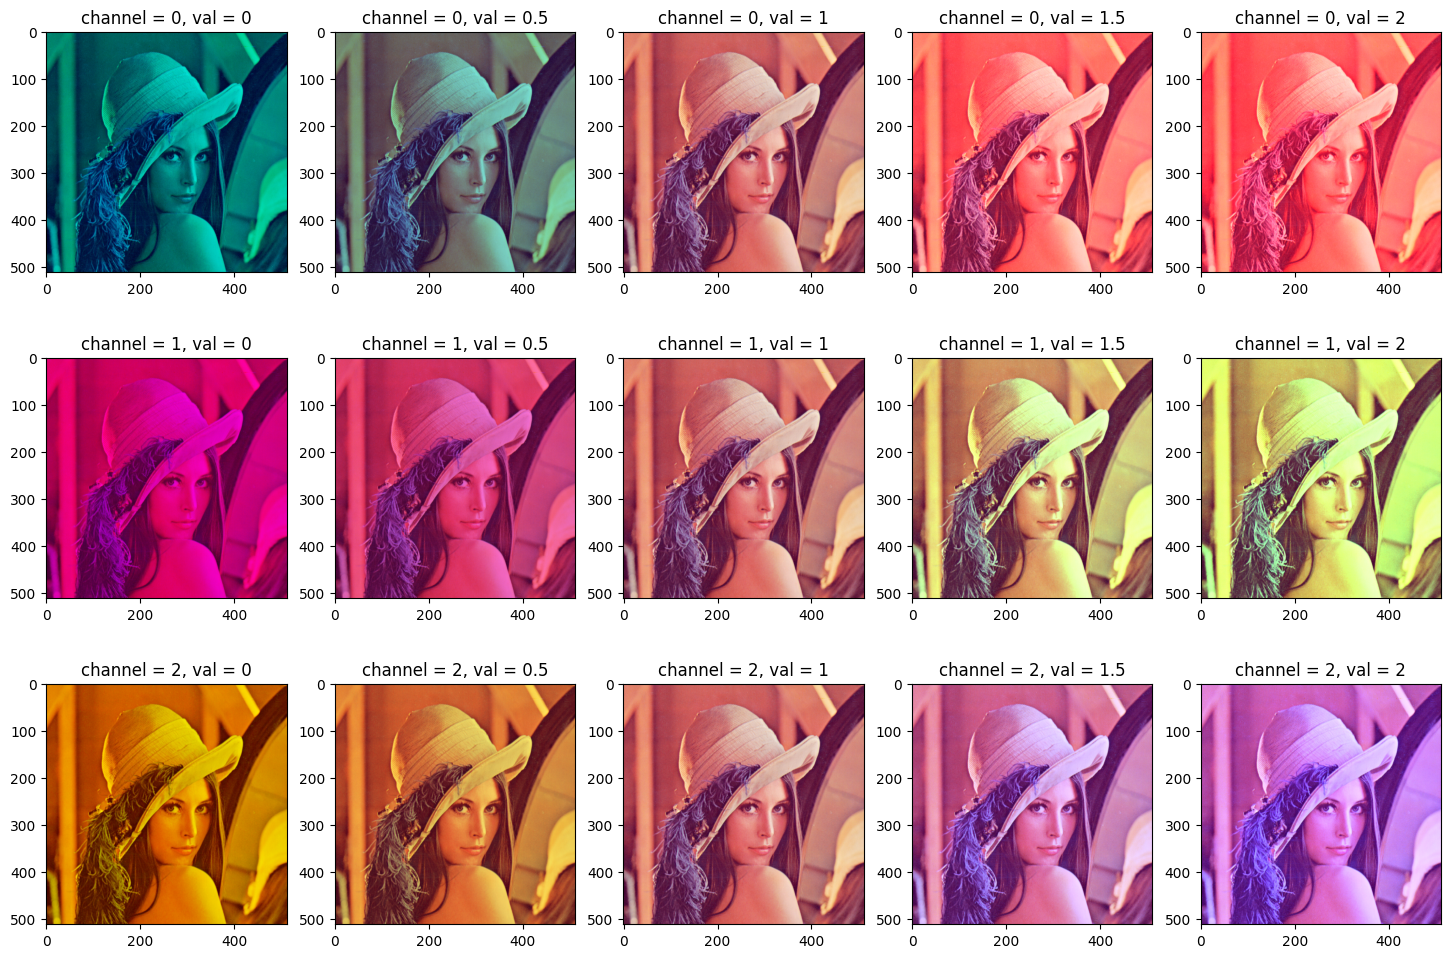

In [241]:
draw_shift(img, img.shape[-1], [0, 0.5, 1, 1.5, 2])

Функция get_rect(image, rect_coord, color) извлекает из данного изображения прямоугольный участок, заданный координатами rect_coord, и заменяет его константным цветом color.

In [242]:
def get_rect(image: np.ndarray, rect_coord: list[tuple[int, int]], color: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    new_image = image.copy()
    rect = image[rect_coord[0][0]:rect_coord[2][1], rect_coord[1][0]:rect_coord[3][1], :]
    new_image[rect_coord[0][0]:rect_coord[2][1], rect_coord[1][0]:rect_coord[3][1], :] = color
    return rect, new_image

In [243]:
rect, new_image = get_rect(img, [(240, 360), (240, 350), (380, 360), (380, 350)], np.array([110, 300, 70]))

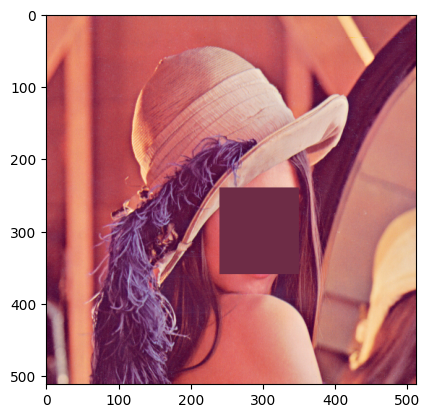

In [244]:
plt.imshow(new_image);

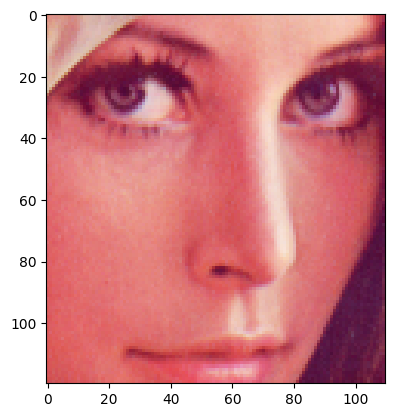

In [245]:
plt.imshow(rect);

# Задание 5 RGB -> HSV

## Имплементация методов для перевода из RGB в HSV и обратно

https://ru.wikipedia.org/wiki/HSV_(цветовая_модель)

In [246]:
def rgb_to_hsv(image: np.ndarray) -> np.ndarray:
    """
    input:
        R, G, B: [0, 255]
    output:
        H: [0°, 360°]
        S: [0%, 100%]
        V: [0%, 100%]
    """
    temp_image = image.copy().astype(np.float64) / 255

    r, g, b = temp_image[:, :, 0], temp_image[:, :, 1], temp_image[:, :, 2]

    MAX = temp_image.max(axis=-1)
    MIN = temp_image.min(axis=-1)

    delta = MAX - MIN

    max_is_r = MAX == r
    max_is_g = MAX == g
    max_is_b = MAX == b
    g_geq_b = g >= b

    H = np.zeros_like(r)

    H[max_is_r & g_geq_b] = (60 * (g - b) / delta)[max_is_r & g_geq_b]
    H[max_is_r & np.invert(g_geq_b)] = (60 * (g - b) / delta + 360)[max_is_r & np.invert(g_geq_b)]
    H[max_is_g] = (60 * (b - r) / delta + 120)[max_is_g]
    H[max_is_b] = (60 * (r - g) / delta + 240)[max_is_b]

    H = np.nan_to_num(H)

    S = np.zeros_like(delta)
    S[MAX != 0] = (1 - MIN / MAX)[MAX != 0]

    return np.stack((H.astype(np.int16) % 360, S * 100, MAX * 100), axis=-1)

In [247]:
def hsv_to_rgb(image: np.ndarray) -> np.ndarray:
    """
    input:
        H: [0°, 360°]
        S: [0%, 100%]
        V: [0%, 100%]
    output:
        R, G, B: [0, 255]
    """
    temp_image = image.copy()
    H, S, V = temp_image[:, :, 0], temp_image[:, :, 1], temp_image[:, :, 2]

    H_i = np.floor(H / 60) % 6

    V_min = (100 - S) * V / 100
    alpha = (V - V_min) * (H % 60) / 60
    V_inc = V_min + alpha
    V_dec = V - alpha

    r, g, b = np.zeros_like(H), np.zeros_like(H), np.zeros_like(H)

    H_0 = H_i == 0
    H_1 = H_i == 1
    H_2 = H_i == 2
    H_3 = H_i == 3
    H_4 = H_i == 4
    H_5 = H_i == 5

    r[H_0], g[H_0], b[H_0] = V[H_0], V_inc[H_0], V_min[H_0]
    r[H_1], g[H_1], b[H_1] = V_dec[H_1], V[H_1], V_min[H_1]
    r[H_2], g[H_2], b[H_2] = V_min[H_2], V[H_2], V_inc[H_2]
    r[H_3], g[H_3], b[H_3] = V_min[H_3], V_dec[H_3], V[H_3]
    r[H_4], g[H_4], b[H_4] = V_inc[H_4], V_min[H_4], V[H_4]
    r[H_5], g[H_5], b[H_5] = V[H_5], V_min[H_5], V_dec[H_5]

    c = 255 / 100

    return (np.stack((r, g, b), axis=-1) * c).astype(np.uint8)

## Демонстрация функции по переводу из одного представления в другое

In [248]:
fig, ax = plt.subplots(1, 2);
ax[0].set_title('src rgb');
ax[0].imshow(img);
ax[1].set_title(r'src rgb $\rightarrow$ hsv $\rightarrow$ rgb');
ax[1].imshow(hsv_to_rgb(rgb_to_hsv(img)));

Видно, что функции реализованы верно, поскольку исходное изображение не поменялось (за исключением точного значения пикселей -- ошибка округления).

## Применеие функции shift_image(...) к изображению в формате HSV (собственная реализация перевода в HSV)

In [249]:
# Вспомогательная функция для отображения работы функции shift_image(...) для HSV

def draw_shift(img: np.ndarray, n_channel: int, vals: list) -> None:
    fig, ax = plt.subplots(n_channel, len(vals), figsize=(18, 12))
    for channel in range(n_channel):
        for i, val in enumerate(vals):
            ax[channel, i].set_title(f'channel = {channel}, val = {val}')
            ax[channel, i].imshow(hsv_to_rgb(shift_image(rgb_to_hsv(img), channel, val, 100 if channel != 0 else None, 360 if channel == 0 else None)))

In [250]:
draw_shift(img, img.shape[-1], [0, 0.5, 1, 2, 4]);

## Применеие функции shift_image(...) к изображению в формате HSV (библиотечная версия перевода в HSV)

In [251]:
def draw_shift(img: np.ndarray, n_channel: int, vals: list) -> None:
    fig, ax = plt.subplots(n_channel, len(vals), figsize=(18, 12))
    for channel in range(n_channel):
        for i, val in enumerate(vals):
            ax[channel, i].set_title(f'channel = {channel}, val = {val}')
            ax[channel, i].imshow(cv2.cvtColor(shift_image(cv2.cvtColor(img, cv2.COLOR_RGB2HSV), channel, val, 180 if channel == 0 else 255), cv2.COLOR_HSV2RGB))

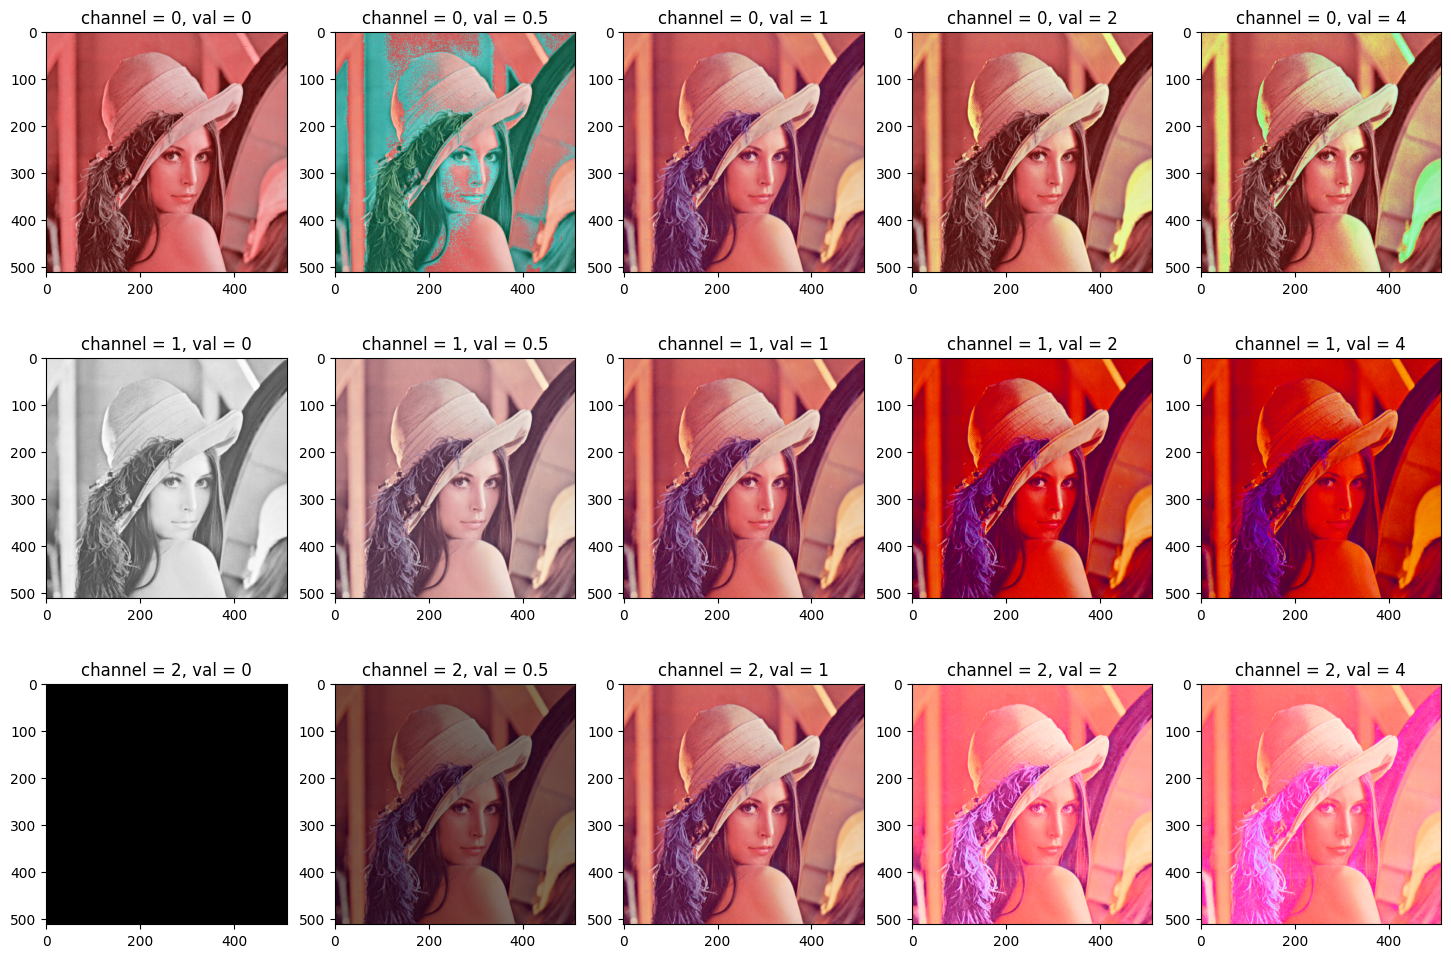

In [252]:
draw_shift(img, img.shape[-1], [0, 0.5, 1, 2, 4])